In [1]:
import pandas as pd
import numpy as np
import pickle
import weighted_sentiment_functions_final as wsff
import stock_price_calculation_trials as spct
from datetime import datetime
from tqdm import tqdm

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# To do: organise the print statements, write code to save output lists into pickle files.

In [3]:
all_data = pd.read_csv('final_all_mdna_data.csv', sep='.@', header=None, names=['DELETE', 'CIK', 'TICKER', 'DATE', 'TEXT'], dtype={'CIK': object}, engine='python', parse_dates=[3], infer_datetime_format=True, encoding='utf-8')
all_data

,DELETE,CIK,TICKER,DATE,TEXT
0,NaN,0000002488,AMD,2019-02-08,Our 2018 financial results demonstrate the suc...
1,NaN,0000002488,AMD,2018-02-27,2017 was an important year for AMD as we launc...
2,NaN,0000002488,AMD,2017-02-21,As we continued to focus on our strategy to im...
3,NaN,0000002488,AMD,2016-02-18,We faced a challenging business environment in...
4,NaN,0000002488,AMD,2015-02-19,"Net revenue for 2014 was $5.5 billion, an incr..."
...,...,...,...,...,...
233,NaN,0000766704,WELL,2009-03-02,"Health Care REIT, Inc., an S&P 500 company, is..."
234,NaN,0000766704,WELL,2008-02-28,"Health Care REIT, Inc. is an equity real esta..."
235,NaN,0000766704,WELL,2007-03-01,"Health Care REIT, Inc. is a self-administered,..."
236,NaN,0000766704,WELL,2006-03-10,"Health Care REIT, Inc. is a self-administered,..."


In [4]:
new_all_data = all_data.drop(['DELETE'], axis=1)
new_all_data

,CIK,TICKER,DATE,TEXT
0,0000002488,AMD,2019-02-08,Our 2018 financial results demonstrate the suc...
1,0000002488,AMD,2018-02-27,2017 was an important year for AMD as we launc...
2,0000002488,AMD,2017-02-21,As we continued to focus on our strategy to im...
3,0000002488,AMD,2016-02-18,We faced a challenging business environment in...
4,0000002488,AMD,2015-02-19,"Net revenue for 2014 was $5.5 billion, an incr..."
...,...,...,...,...
233,0000766704,WELL,2009-03-02,"Health Care REIT, Inc., an S&P 500 company, is..."
234,0000766704,WELL,2008-02-28,"Health Care REIT, Inc. is an equity real esta..."
235,0000766704,WELL,2007-03-01,"Health Care REIT, Inc. is a self-administered,..."
236,0000766704,WELL,2006-03-10,"Health Care REIT, Inc. is a self-administered,..."


In [5]:
# Check dataframe for any missing values:
# new_all_data.isnull().values.any()
# new_all_data.isnull().sum().sum()

In [6]:
# load the trained classifier model from disk
filename = 'finalised_classifier_model.sav'
model = pickle.load(open(filename, 'rb'))

To-do: Might need to modify this, instead round each value maybe?
In regular sent analysis you get 0, 0.5, 1. With averaging justifications you get between 0 and 1, i.e. scaled/weighted.
Below is more like weighted mode aggregated. Whereas above 'weighted' function is like weighted mean aggregated.
But mode doesn't make much sense because it gets rid of the weight, so it is more like checking if 5 mined justifications can
capture the full sentiment of the entire document.
Read what you wrote in your thesis and then clarify all these sentiment score terms below!!!!!!

In [7]:
weighted_sentiments = []
for i, row in tqdm(new_all_data.iterrows(), desc='Getting sentiment scores', unit='Filings'):
    weighted_sentiment = wsff.get_weighted_sentiment(row['TEXT'], model, clustering_model='Agglomerative')
    weighted_sentiments.append(weighted_sentiment)
print(weighted_sentiments)
new_all_data['weighted_sentiments'] = weighted_sentiments

unweighted_sentiments = []
for i, row in tqdm(new_all_data.iterrows(), desc='Getting sentiment scores', unit='Filings'):
    unweighted_sentiment = wsff.get_unweighted_sentiment(row['TEXT'], model, clustering_model='Agglomerative')
    unweighted_sentiments.append(unweighted_sentiment)
print(unweighted_sentiments)
new_all_data['unweighted_sentiments'] = unweighted_sentiments

weighted_sentiments_DBSCAN = []
for i, row in tqdm(new_all_data.iterrows(), desc='Getting sentiment scores', unit='Filings'):
    weighted_sentiment = wsff.get_weighted_sentiment(row['TEXT'], model, clustering_model='DBSCAN')
    weighted_sentiments_DBSCAN.append(weighted_sentiment)
print(weighted_sentiments_DBSCAN)
new_all_data['weighted_sentiments_DBSCAN'] = weighted_sentiments_DBSCAN


weighted_sentiments_MeanShift = []
for i, row in tqdm(new_all_data.iterrows(), desc='Getting sentiment scores', unit='Filings'):
    weighted_sentiment = wsff.get_weighted_sentiment(row['TEXT'], model, clustering_model='MeanShift')
    weighted_sentiments_MeanShift.append(weighted_sentiment)
print(weighted_sentiments_MeanShift)
new_all_data['weighted_sentiments_MeanShift'] = weighted_sentiments_MeanShift

Getting sentiment scores: 238Filings [12:08,  3.06s/Filings]


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.59999999999999998, 0.5, 0.69999999999999996, 0.69999999999999996, 0.59999999999999998, 0.5, 0.69999999999999996, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.59999999999999998, 0.5, 0.59999999999999998, 0.59999999999999998, 0.5, 0.5, 0.40000000000000002, 0.59999999999999998, 0.59999999999999998, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.59999999999999998, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.69999999999999996, 0.59999999999999998, 0.5, 0.5, 0.5, 0.59999999999999998, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.59999999999999998, 0.5, 0.5, 0.5, 0.5, 0.59999999999999998, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.59999999999999998, 0.69999999999999996, 0.69999

Getting sentiment scores: 238Filings [12:04,  3.04s/Filings]


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

Getting sentiment scores: 238Filings [11:51,  2.99s/Filings]


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.66666666666666663, 0.5, 0.5, 0.66666666666666663, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.59999999999999998, 0.33333333333333331, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5

Getting sentiment scores: 238Filings [12:17,  3.10s/Filings]


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.66666666666666663, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.58333333333333337, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.625, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.625, 0.5, 0.66666666666666663, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 

In [8]:
full_sentiments_mean = []

for i, row in tqdm(new_all_data.iterrows(), desc='Getting sentiment scores', unit='Filings'):
    full_sentiment_mean = wsff.get_full_sentiment_mean(row['TEXT'], model)
    full_sentiments_mean.append(full_sentiment_mean)
print(full_sentiments_mean)
new_all_data['full_mean'] = full_sentiments_mean

full_sentiments_mean_unrounded = []

for i, row in tqdm(new_all_data.iterrows(), desc='Getting sentiment scores', unit='Filings'):
    full_sentiment_mean_unrounded = wsff.get_full_sentiment_mean_unrounded(row['TEXT'], model)
    full_sentiments_mean_unrounded.append(full_sentiment_mean_unrounded)
print(full_sentiments_mean_unrounded)
new_all_data['full_mean_unrounded'] = full_sentiments_mean_unrounded

full_sentiments_mode = []

for i, row in tqdm(new_all_data.iterrows(), desc='Getting sentiment scores', unit='Filings'):
    full_sentiment_mode = wsff.get_full_sentiment_mode(row['TEXT'], model)
    full_sentiments_mode.append(full_sentiment_mode)
print(full_sentiments_mode)
new_all_data['full_mode'] = full_sentiments_mode

Getting sentiment scores: 238Filings [03:14,  1.22Filings/s]


[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0,

Getting sentiment scores: 238Filings [03:10,  1.25Filings/s]


[0.5357142857142857, 0.48148148148148145, 0.50980392156862742, 0.5, 0.52272727272727271, 0.5, 0.51282051282051277, 0.52173913043478259, 0.5, 0.56756756756756754, 0.56666666666666665, 0.53703703703703709, 0.5, 0.61290322580645162, 0.52083333333333337, 0.5, 0.51351351351351349, 0.51351351351351349, 0.51388888888888884, 0.51315789473684215, 0.51315789473684215, 0.51351351351351349, 0.51351351351351349, 0.52702702702702697, 0.51351351351351349, 0.51315789473684215, 0.51249999999999996, 0.51219512195121952, 0.52439024390243905, 0.51315789473684215, 0.55555555555555558, 0.53125, 0.5, 0.515625, 0.51351351351351349, 0.5, 0.5, 0.48837209302325579, 0.52702702702702697, 0.53125, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.578125, 0.51428571428571423, 0.54411764705882348, 0.51351351351351349, 0.51219512195121952, 0.51428571428571423, 0.51666666666666672, 0.5, 0.54347826086956519, 0.51724137931034486, 0.48484848484848486, 0.5, 0.5625, 0.53846153846153844, 0.56666666666666665,

Getting sentiment scores: 238Filings [03:11,  1.24Filings/s]


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

Note the time difference in weighted vs full sentiment scores:
weighted:
Getting sentiment scores: 239Filings [09:29,  2.38s/Filings]
Getting sentiment scores: 239Filings [09:13,  2.32s/Filings]

Full:
Getting sentiment scores: 239Filings [00:04, 51.05Filings/s]
Getting sentiment scores: 239Filings [00:04, 50.69Filings/s]
Getting sentiment scores: 239Filings [00:04, 50.40Filings/s]

Likely caused by the embeddings extraction time.

In [9]:
new_all_data.head()

,CIK,TICKER,DATE,TEXT,weighted_sentiments,unweighted_sentiments,weighted_sentiments_DBSCAN,weighted_sentiments_MeanShift,full_mean,full_mean_unrounded,full_mode
0,0000002488,AMD,2019-02-08,Our 2018 financial results demonstrate the suc...,0.5,0.5,0.5,0.5,1.0,0.535714,0.5
1,0000002488,AMD,2018-02-27,2017 was an important year for AMD as we launc...,0.5,0.5,0.5,0.5,0.0,0.481481,0.5
2,0000002488,AMD,2017-02-21,As we continued to focus on our strategy to im...,0.5,0.5,0.5,0.5,1.0,0.509804,0.5
3,0000002488,AMD,2016-02-18,We faced a challenging business environment in...,0.5,0.5,0.5,0.5,0.0,0.500000,0.5
4,0000002488,AMD,2015-02-19,"Net revenue for 2014 was $5.5 billion, an incr...",0.5,0.5,0.5,0.5,1.0,0.522727,0.5


Trial outputs for all the below stock calculations:
1:
[23.049999237060547, 331.04998779296875, 26.155519485473633]
[Timestamp('2019-02-08 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2010-11-18 00:00:00')]

2:
[52.259998321533203, 517.46002197265625, 16.585308074951172]
[Timestamp('2020-02-10 00:00:00'), Timestamp('2020-01-31 00:00:00'), Timestamp('2011-11-18 00:00:00')]
[27.090000152587891, 371.19000244140625, 27.930322647094727]
[Timestamp('2019-05-08 00:00:00'), Timestamp('2019-04-30 00:00:00'), Timestamp('2011-02-18 00:00:00')]

3:
[126.72451215316249, 56.308727096605168, -36.589643787566928]
[17.527119519516933, 12.125061509907129, 6.7855779450558877]

In [10]:
def get_current_stock_price_date(ticker, date):
    given_date = date
    while True:
        try:
            stock_price = spct.get_stock_adj_close(ticker, given_date)
            break
        except KeyError:
            given_date = spct.add_days(given_date,1)
    return given_date, stock_price

stock_prices = []
given_dates = []


    
for i, row in tqdm(new_all_data.iterrows(), desc='Getting stock prices', unit='Filings'):
    given_date, stock_price = get_current_stock_price_date(row['TICKER'], row['DATE'])
    stock_prices.append(stock_price)
    given_dates.append(given_date)
    
print(stock_prices)
print(given_dates)

Getting stock prices: 238Filings [04:07,  1.04s/Filings]


[23.049999237060547, 12.529999732971191, 14.0, 1.9099999666213989, 3.059999942779541, 3.7000000476837158, 2.5999999046325684, 7.4600000381469727, 9.1800003051757813, 7.929999828338623, 2.119999885559082, 7.130000114440918, 14.789999961853027, 40.619998931884766, 17.959999084472656, 14.529999732971191, 1626.22998046875, 1429.949951171875, 827.46002197265625, 587.0, 354.52999877929688, 358.69000244140625, 272.760009765625, 179.46000671386719, 171.13999938964844, 125.41000366210938, 58.819999694824219, 75.19000244140625, 40.330001831054688, 39.189998626708984, 34.75, 42.939998626708984, 331.04998779296875, 387.5, 324.45999145507813, 161.08000183105469, 177.77000427246094, 125.08000183105469, 85.019996643066406, 63.569999694824219, 28.89457893371582, 24.875455856323242, 24.219139099121094, 15.710981369018555, 16.892948150634766, 18.17902946472168, 15.811397552490234, 13.947021484375, 10.736077308654785, 8.7257328033447266, 6.4457430839538574, 8.8771677017211914, 9.9546632766723633, 57.1461

In [11]:
# Check to make sure it isn't SBUX out of date 2019, index 209 should now return SBUX 2018-11-16
print(new_all_data.iloc[209])
print(given_dates[209])
date_one_yearsbux = spct.add_years(given_dates[209], 1)
print(date_one_yearsbux) # Should be 2019-11-16

CIK                                                                     0000829224
TICKER                                                                        SBUX
DATE                                                           2018-11-16 00:00:00
TEXT                             Starbucks results for fiscal 2018 reflect the ...
weighted_sentiments                                                            0.5
unweighted_sentiments                                                          0.5
weighted_sentiments_DBSCAN                                                0.666667
weighted_sentiments_MeanShift                                                  0.5
full_mean                                                                        1
full_mean_unrounded                                                       0.536585
full_mode                                                                      0.5
Name: 209, dtype: object
2018-11-16 00:00:00
2019-11-16 00:00:00


In [12]:
# To-do: create 6 month window as well.
# Getting an error at index 209: issue was SBUX 2019 is in Nov, so next year is Nov 2020, hasn't happened yet.
stock_prices_next_year = []
given_dates_next_year = []
stock_prices_three_months = []
given_dates_three_months = []

for i, row in tqdm(new_all_data.iterrows(), desc='Getting stock prices', unit='Filings'):
    date_one_year = spct.add_years(given_dates[i], 1)
    given_date, stock_price = get_current_stock_price_date(row['TICKER'], date_one_year)
    stock_prices_next_year.append(stock_price)
    given_dates_next_year.append(given_date)
    
for i, row in tqdm(new_all_data.iterrows(), desc='Getting stock prices', unit='Filings'):
    date_three_months = spct.add_months(given_dates[i], 3)
    given_date, stock_price = get_current_stock_price_date(row['TICKER'], date_three_months)
    stock_prices_three_months.append(stock_price)
    given_dates_three_months.append(given_date)

print(stock_prices_next_year)
print(given_dates_next_year)
print(stock_prices_three_months)
print(given_dates_three_months)

Getting stock prices: 238Filings [05:04,  1.28s/Filings]
Getting stock prices: 238Filings [04:12,  1.06s/Filings]


[53.799999237060547, 23.479999542236328, 11.720000267028809, 14.0, 1.9099999666213989, 3.0799999237060547, 3.690000057220459, 2.5299999713897705, 7.2800002098083496, 8.8500003814697266, 8.0500001907348633, 2.0899999141693115, 6.7600002288818359, 15.079999923706055, 40.069999694824219, 16.940000534057617, 2004.199951171875, 1633.31005859375, 1386.22998046875, 830.3800048828125, 574.80999755859375, 364.47000122070313, 403.010009765625, 265.0, 192.14999389648438, 169.63999938964844, 118.87000274658203, 64.349998474121094, 72.080001831054688, 41.509998321533203, 36.189998626708984, 34.990001678466797, 532.04998779296875, 337.0, 365.66000366210938, 324.55999755859375, 175.78999328613281, 175.8800048828125, 123.58000183105469, 87.129997253417969, 23.020000457763672, 30.102512359619141, 24.921520233154297, 23.749292373657227, 15.710981369018555, 16.892948150634766, 18.186752319335938, 16.034830093383789, 13.85399341583252, 10.887096405029297, 9.195281982421875, 5.9065537452697754, 8.877167701

[27.090000152587891, 13.359999656677246, 11.039999961853027, 3.8399999141693115, 2.2799999713897705, 4.0900001525878906, 4.0199999809265137, 6.0199999809265137, 8.6700000762939453, 8.4700002670288086, 4.5300002098083496, 6.9200000762939453, 14.310000419616699, 30.479999542236328, 16.719999313354492, 15.510000228881836, 1911.52001953125, 1569.6800537109375, 948.95001220703125, 659.59002685546875, 421.77999877929688, 304.1300048828125, 253.80999755859375, 230.03999328613281, 195.07000732421875, 141.72999572753906, 80.519996643066406, 74.529998779296875, 63.220001220703125, 31.610000610351563, 34.869998931884766, 43.619998931884766, 371.19000244140625, 274.77999877929688, 320.010009765625, 216.49000549316406, 179.77999877929688, 138.55999755859375, 112.94000244140625, 64.629997253417969, 27.898456573486328, 23.66253662109375, 25.415637969970703, 19.174156188964844, 16.49390983581543, 18.6829833984375, 17.601566314697266, 14.630092620849609, 13.345221519470215, 8.6953153610229492, 6.238107

In [13]:
percent_changes_one_year = []
percent_changes_three_months = []

for old, new in zip(stock_prices, stock_prices_next_year):
    change = spct.percent_change(old,new)
    percent_changes_one_year.append(change)
    
for old, new in zip(stock_prices, stock_prices_three_months):
    change = spct.percent_change(old,new)
    percent_changes_three_months.append(change)

new_all_data['% change 1 year'] = percent_changes_one_year
new_all_data['% change 3 months'] = percent_changes_three_months

print(percent_changes_one_year)
print(percent_changes_three_months)

[133.40564432886893, 87.390263708079146, -16.285712378365652, 632.98430600313645, -37.581699270018397, -16.756759891551766, 41.923084329571516, -66.085791441655147, -20.697168106804874, 11.601520467168138, 279.7170106267215, -70.687238700932426, -54.293439849104089, -62.875430033876803, 123.10691390550681, 16.586378839482695, 23.242098303597729, 14.221484273293411, 67.528332929486055, 41.461670337787474, 62.132964639876995, 1.6114189801654886, 47.752601311284657, 47.665212351473173, 12.2764956069684, 35.268315474025016, 102.09113118550701, -14.416815554345153, 78.725510931050934, 5.9198769485107352, 4.1438809401697387, -18.514199353740157, 60.71590618082152, -13.032258064516128, 12.698025424418297, 101.48993907946536, -1.1138048820055388, 40.614008880790777, 45.354042237700966, 37.061503337575083, -20.331074868501926, 21.012907395492817, 2.9001077666657951, 51.163646724767361, -6.9968058332778211, -7.0745323152849844, 15.023053837967623, 14.969566163985506, 29.041483379262335, 24.76999

In [3]:
new_all_data.head()
# To-do balance the training data to have less neutral labels

NameError: name 'new_all_data' is not defined

In [15]:
new_all_data.to_pickle("./full_data_df_1.pkl")

In [4]:
# Name used in the functions below is still new_all_data, so maybe change the name below when reopening this file.
new_all_data = pd.read_pickle("./full_data_df_1.pkl")
new_all_data.head()

,CIK,TICKER,DATE,TEXT,weighted_sentiments,unweighted_sentiments,weighted_sentiments_DBSCAN,weighted_sentiments_MeanShift,full_mean,full_mean_unrounded,full_mode,% change 1 year,% change 3 months
0,0000002488,AMD,2019-02-08,Our 2018 financial results demonstrate the suc...,0.5,0.5,0.5,0.5,1.0,0.535714,0.5,133.405644,17.527120
1,0000002488,AMD,2018-02-27,2017 was an important year for AMD as we launc...,0.5,0.5,0.5,0.5,0.0,0.481481,0.5,87.390264,6.624102
2,0000002488,AMD,2017-02-21,As we continued to focus on our strategy to im...,0.5,0.5,0.5,0.5,1.0,0.509804,0.5,-16.285712,-21.142857
3,0000002488,AMD,2016-02-18,We faced a challenging business environment in...,0.5,0.5,0.5,0.5,0.0,0.500000,0.5,632.984306,101.047119
4,0000002488,AMD,2015-02-19,"Net revenue for 2014 was $5.5 billion, an incr...",0.5,0.5,0.5,0.5,1.0,0.522727,0.5,-37.581699,-25.490196


Choosing spearmean versus pearson correlation:
'I noted in a comment to the post that usually spearmanr() is used for ranks and it does not seem like you are correlating ranked data. I'm making that assessment based on non-integral values of the 2 sequences-usually ranks are non-negative integral values.

Given the second issue (as it seems) I'd recommend using pearsonr(). Provided your version of scipy is 1.3.X or greater, the error message is informative and tells you exactly this issue:'

Note: Set p-value to 0.05 or less to be statistically significant. 
'The null hypothesis is that the two variables are uncorrelated. The p-value is a number between zero and one that represents the probability that your data would have arisen if the null hypothesis were true.'

In [17]:
# This block is for checking logit outputs on individual columns
# from scipy import special, stats

# normalised_sentiments_weighted = special.logit(new_all_data['full_mean_unrounded'])
# normalised_sentiments_weighted_fixed = np.nan_to_num(normalised_sentiments_weighted)
# # normalised_sentiments_weighted.values
# normalised_sentiments_weighted_fixed
# # np.isnan(normalised_sentiments_weighted_fixed).any()
# # np.isinf(normalised_sentiments_weighted_fixed).any()

In [25]:
# To-do: format printed lines with % stuff to make it more organised, google how to print with even spacing between
# To-do: Reinclude MeanShift in the list below after restarting kernel with updated .py imports
# To-do: Maybe calculate similarity scores between weighted sentiments lists and full sentiments lists
# Using np.nan_to_num() to solve the infs error. Check the make sure the maths for this is okay
from scipy import special, stats


def logit_correlate(sentiments, percent_changes):
    normalised_sentiments = special.logit(sentiments)
#     print(normalised_sentiments.values)
    normalised_sentiments_fixed = np.nan_to_num(normalised_sentiments)
#     print(np.isnan(normalised_sentiments_fixed).any())
#     print(np.isinf(normalised_sentiments_fixed).any())
#     print(np.isnan(percent_changes.values).any())
#     print(np.isinf(percent_changes.values).any())
    r, p_value = stats.pearsonr(normalised_sentiments_fixed, percent_changes)
    return r, p_value

# for sentiment in ['weighted_sentiments', 'unweighted_sentiments', 'weighted_sentiments_DBSCAN', 'full_mean', 'full_mean_unrounded', 'full_mode']:
#     print(sentiment)
for sentiment in ['weighted_sentiments', 'unweighted_sentiments', 'weighted_sentiments_DBSCAN', 'weighted_sentiments_MeanShift', 'full_mean', 'full_mean_unrounded', 'full_mode']:
    r_1yr, p_value_1yr = stats.pearsonr(new_all_data[sentiment], new_all_data['% change 1 year'])
#     print(sentiment, '1 year', 'r=', r_1yr, 'p=', p_value_1yr)
    time = '1 year'
    print(f'{sentiment:30} {time:10} r={r_1yr:<25} p={p_value_1yr}')
print('\n')

# for sentiment in ['weighted_sentiments', 'unweighted_sentiments', 'weighted_sentiments_DBSCAN', 'full_mean', 'full_mean_unrounded', 'full_mode']:
for sentiment in ['weighted_sentiments', 'unweighted_sentiments', 'weighted_sentiments_DBSCAN', 'weighted_sentiments_MeanShift', 'full_mean', 'full_mean_unrounded', 'full_mode']:
    r_3month, p_value_3month = stats.pearsonr(new_all_data[sentiment], new_all_data['% change 3 months'])
#     print(sentiment, '3 months', 'r=', r_3month, 'p=', p_value_3month)
    time = '3 months'
    print(f'{sentiment:30} {time:10} r={r_3month:<25} p={p_value_3month}')
    

weighted_sentiments            1 year     r=-0.050994704451746364     p=0.4335826338188967
unweighted_sentiments          1 year     r=nan                       p=nan
weighted_sentiments_DBSCAN     1 year     r=-0.06924535039202072      p=0.2873655870349446
weighted_sentiments_MeanShift  1 year     r=-0.04549583883503607      p=0.4848381950662208
full_mean                      1 year     r=-0.07114038012496435      p=0.27434649762809193
full_mean_unrounded            1 year     r=-0.08882127181888153      p=0.1720160449195358
full_mode                      1 year     r=nan                       p=nan


weighted_sentiments            3 months   r=-0.07086475034518555      p=0.27621481315395385
unweighted_sentiments          3 months   r=nan                       p=nan
weighted_sentiments_DBSCAN     3 months   r=-0.04400432937353048      p=0.49928259331642083
weighted_sentiments_MeanShift  3 months   r=-0.003751647475437115     p=0.9540886896304036
full_mean                      3 months

In [ ]:
# Results from correlation first attempt:

# weighted_sentiments            1 year     r=-0.050994704451746364     p=0.4335826338188967
# unweighted_sentiments          1 year     r=nan                       p=nan
# weighted_sentiments_DBSCAN     1 year     r=-0.06924535039202072      p=0.2873655870349446
# weighted_sentiments_MeanShift  1 year     r=-0.04549583883503607      p=0.4848381950662208
# full_mean                      1 year     r=-0.07114038012496435      p=0.27434649762809193
# full_mean_unrounded            1 year     r=-0.08882127181888153      p=0.1720160449195358
# full_mode                      1 year     r=nan                       p=nan


# weighted_sentiments            3 months   r=-0.07086475034518555      p=0.27621481315395385
# unweighted_sentiments          3 months   r=nan                       p=nan
# weighted_sentiments_DBSCAN     3 months   r=-0.04400432937353048      p=0.49928259331642083
# weighted_sentiments_MeanShift  3 months   r=-0.003751647475437115     p=0.9540886896304036
# full_mean                      3 months   r=-0.0534469143564483       p=0.4117689600688962
# full_mean_unrounded            3 months   r=-0.12512998328588287      p=0.053876058043276866
# full_mode                      3 months   r=nan                       p=nan

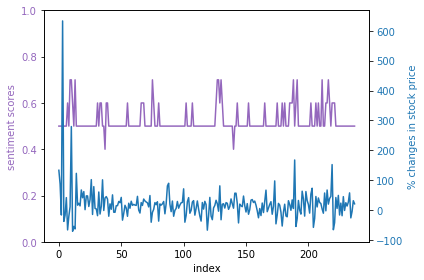

In [26]:
# To-do: maybe leave x axis unlabelled as it means nothing.
import numpy as np
import matplotlib.pyplot as plt

t = new_all_data.index
data1 = new_all_data['weighted_sentiments']
data2 = new_all_data['% change 1 year']

fig, ax1 = plt.subplots()

color = 'tab:purple'
ax1.set_xlabel('index')
ax1.set_ylabel('sentiment scores', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('% changes in stock price', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

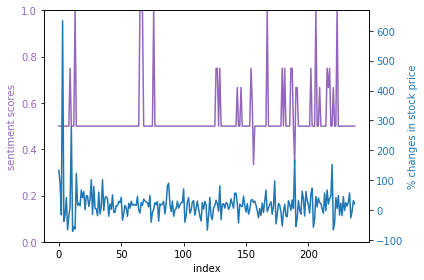

In [27]:
t = new_all_data.index
data1 = new_all_data['weighted_sentiments_DBSCAN']
data2 = new_all_data['% change 1 year']

fig, ax1 = plt.subplots()

color = 'tab:purple'
ax1.set_xlabel('index')
ax1.set_ylabel('sentiment scores', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('% changes in stock price', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()